In [1]:
import pandas as pd
import datetime
import itertools
import matplotlib.pyplot as plt

In [2]:
header_names = [
    "call",
    "conversation_topic",
    "person_and_type",
    "start",
    "end",
    "caller",
    "receiver",
]
gender_and_position = {"caller_F", "receiver_F", "caller_M", "receiver_M"}
gender_types = dict.fromkeys(gender_and_position, 0)
cue_types = {"laughter": 0, "silence": 0, "filler": 0, "bc": 0}


def read_in_data(location):
    return pd.read_csv(location, sep=",", names=header_names)


def receiver_and_caller_column(df):
    """
    Takes in the dataframe, header names and gender/position.
    This then looks at person_and_type column and fills the caller and receiver column with the appropriate value
    """
    call_id = get_all_call_ids(df)
    for call in call_id:
        temp_df = get_call_df(df, call)  # get dataframe of only one call id
        for gp in gender_and_position:
            if temp_df["person_and_type"].str.contains(gp).any():
                if "receiver" in gp:
                    df.loc[df.call == call, "receiver"] = gp
                else:
                    df.loc[df.call == call, "caller"] = gp
    return df


def get_conversation_topic_df(df, topic):
    """
    Gets the rows that match the conversation topic specified.
    """
    return df.loc[df["conversation_topic"] == topic]


def remove_conversation_topic_df(df, topic):
    """
    Gets the rows that do not contain a specific topic. Can pass a string containing topics to remove.
    Delimited by a comma
    """
    for individual_topic in topic.split(","):
        df = df.loc[df["conversation_topic"] != individual_topic]
    return df


def get_call_df(df, call_id):
    """
    This gets the rows containing the call_id.
    """
    return df.loc[df["call"] == call_id]


def get_all_call_ids(df):
    """
    Returns an array of the names of the call ids
    """
    return df.call.unique()


def get_all_conversation_topics(df):
    """
    Returns array of all the names of the conversation topics
    """
    return df.conversation_topic.unique()


def get_conversation_only_df(df, non_verbal_speech):
    """
    Return df with non-verbal speech removed
    """
    for cue in non_verbal_speech:
        df = df[~df["person_and_type"].str.contains(cue)]
    return df


def get_rows_by_caller_and_receiver(df, caller, receiver):
    """
    Specify the caller and receiver string and returns the dataframe with those rows.
    """
    return df.loc[(df["caller"] == caller) & (df["receiver"] == receiver)]


def convert_to_minutes_and_seconds(seconds):
    return datetime.timedelta(seconds=seconds)


def get_permutations_of_gender_and_position():
    """
    Takes in the gender_and_position var and returns the possible combinations of size 2
    """
    permutations = list(itertools.permutations(gender_and_position, 2))
    final_permutation = []
    for perm in permutations:
        if "caller" in perm[0]:
            if "receiver" in perm[1]:
                final_permutation.append(perm)
    return [" ".join(i) for i in final_permutation]

In [3]:
def occurrence_of_each_event(df, types):
    """
    This takes in a dataframe and produces the total number of each conversation cue occurred.
    """
    occurrences = df["person_and_type"].value_counts()
    for occurrence_name in occurrences.index:
        for cue_type in types:
            if occurrence_name.count(cue_type) > 1:
                types[cue_type] += occurrences[occurrence_name] * 2
            elif occurrence_name.count(cue_type) == 1:
                types[cue_type] += occurrences[occurrence_name]
    return types


def occurrence_of_event(df, cue):
    # dataframe input should be an individual call.
    # returns a list of two vals. number of times caller did a cue and number of times the receiver did the cue
    if "M" in df["receiver"].iloc[0]:
        receiver_search = f"{cue}_rM"
    else:
        receiver_search = f"{cue}_rF"
    if "M" in df["caller"].iloc[0]:
        caller_search = f"{cue}_cM"
    else:
        caller_search = f"{cue}_cF"
    caller_cue_count = df.person_and_type.str.count(caller_search).sum()
    receiver_cue_count = df.person_and_type.str.count(receiver_search).sum()
    return [caller_cue_count, receiver_cue_count]


def total_time_of_event(df, cue):
    # dataframe input should be an individual call.
    # returns a list of two vals. Length of time caller did cue and length of time the receiver did the cue
    if "M" in df["receiver"].iloc[0]:
        receiver_search = f"{cue}_rM"
    else:
        receiver_search = f"{cue}_rF"
    if "M" in df["caller"].iloc[0]:
        caller_search = f"{cue}_cM"
    else:
        caller_search = f"{cue}_cF"
    caller_cue_time = df[df["person_and_type"].str.contains(caller_search)]
    caller_cue_time = (caller_cue_time["end"] - caller_cue_time["start"]).sum(axis=0) 
    receiver_cue_time = df[df["person_and_type"].str.contains(receiver_search)]
    receiver_cue_time = (receiver_cue_time["end"] - receiver_cue_time["start"]).sum(axis=0) 
    return [caller_cue_time, receiver_cue_time]


def total_time_of_each_event(df, types):
    """
    This calculates the total time of each cue in the dataset, returning a dictionary of each cue
    """
    for cue in types:
        new_df = df[
            df["person_and_type"].str.contains(cue)
        ]  # for each cue, get df of all rows containing cue
        types[cue] = (new_df["end"] - new_df["start"]).sum(
            axis=0
        )  # end time - start time and sum them all
    return types


def mean_time_of_each_event(df, types):
    """
    Gets the mean of each conversation cue. Returns a dictionary.
    """
    for cue in types:
        new_df = df[df["person_and_type"].str.contains(cue)]
        if len(new_df) > 0:
            types[cue] = (new_df["end"] - new_df["start"]).mean(axis=0)
    return types


def mean_call_length(df):
    total = 0
    ids = get_all_call_ids(df)
    for call in ids:
        new_df = df[df["call"].str.match(call)]
        total += new_df.iloc[-1]["end"]
    return total / len(ids)


def individual_call_length(df):
    """
    Gets the the call length of each conversation and returns a dictionary of call id and length of time
    """
    total = {}
    ids = get_all_call_ids(df)
    for call in ids:
        temp_df = df[df["call"].str.match(call)]  # gets the df that matches call id
        total[call] = temp_df.iloc[-1]["end"]
    return total


def total_overlap_occurrence(df):
    """
    Returns the number of times there was two people talking over on another
    """
    permutations = get_permutations_of_gender_and_position()
    return df[df["person_and_type"].isin(permutations)].shape[0]


def total_overlap_time(df):
    permutations = get_permutations_of_gender_and_position()
    new_df = df[df["person_and_type"].isin(permutations)]
    total = (new_df["end"] - new_df["start"]).sum(
        axis=0
    )  # end time - start time and sum them all
    return total


def mean_overlap_time(df):
    """
    Calculates the overlap mean time.
    """
    permutations = get_permutations_of_gender_and_position()
    new_df = df[df["person_and_type"].isin(permutations)]
    return (new_df["end"] - new_df["start"]).mean(axis=0)


In [4]:
df = read_in_data("../data/genderedCorpus.csv")
df = receiver_and_caller_column(df)
occ_count = occurrence_of_each_event(df, cue_types.copy())
time_total = total_time_of_each_event(df, cue_types.copy())
mean_time = mean_time_of_each_event(df, cue_types.copy())
id_call_length = individual_call_length(df)
call_time_total = convert_to_minutes_and_seconds(sum(id_call_length.values()))
total_overlap_occurrences = total_overlap_occurrence(df)
total_overlap_duration = total_overlap_time(df)
mean_overlap_duration = mean_overlap_time(df)
m_m_calls = get_all_call_ids(get_rows_by_caller_and_receiver(df, "caller_M", "receiver_M"))

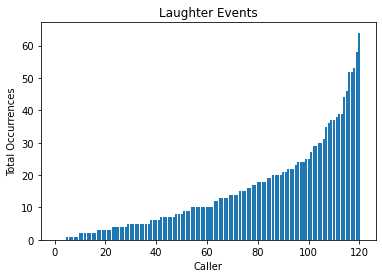

In [5]:
# Visualisation- Laughter
all_ids = get_all_call_ids(df)
laughter_events_list = []
for call in all_ids:
    laughter_events_list.append(occurrence_of_event(get_call_df(df, call), "laughter"))
laughter_events_list = sorted([val for sublist in laughter_events_list for val in sublist])
x = list(range(1, 121))
plt.bar(x, laughter_events_list)
plt.title('Laughter Events')
plt.xlabel('Caller')
plt.ylabel('Total Occurrences')
plt.show()

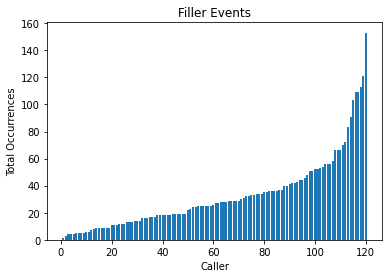

In [6]:
# Visualisation- filler
all_ids = get_all_call_ids(df)
filler_events_list = []
for call in all_ids:
    filler_events_list.append(occurrence_of_event(get_call_df(df, call), "filler"))
filler_events_list = sorted([val for sublist in filler_events_list for val in sublist])
x = list(range(1, 121))
plt.bar(x, filler_events_list)
plt.title('Filler Events')
plt.xlabel('Caller')
plt.ylabel('Total Occurrences')
plt.show()

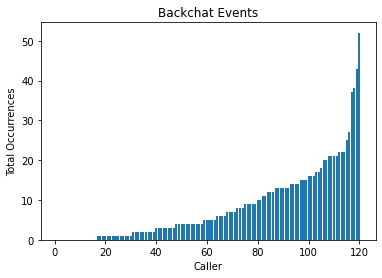

In [7]:
# Visualisation- backchat
all_ids = get_all_call_ids(df)
bc_events_list = []
for call in all_ids:
    bc_events_list.append(occurrence_of_event(get_call_df(df, call), "bc"))
bc_events_list = sorted([val for sublist in bc_events_list for val in sublist])
x = list(range(1, 121))
plt.bar(x, bc_events_list)
plt.title('Backchat Events')
plt.xlabel('Caller')
plt.ylabel('Total Occurrences')
plt.show()

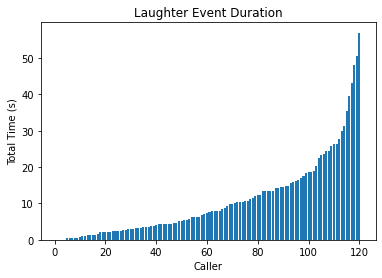

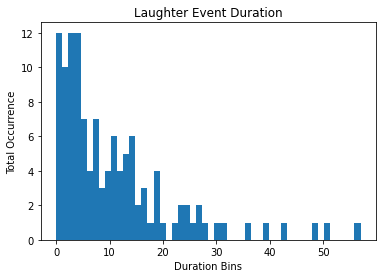

In [8]:
# Visualisation of laughter length duration
all_ids = get_all_call_ids(df)
laughter_list = []
for call in all_ids:
    laughter_list.append(total_time_of_event(get_call_df(df, call), "laughter"))
laughter_list = sorted([val for sublist in laughter_list for val in sublist])
x = list(range(1, 121))
plt.bar(x, laughter_list)
plt.title('Laughter Event Duration')
plt.xlabel('Caller')
plt.ylabel('Total Time (s)')
plt.show()

plt.hist(laughter_list, 50)
plt.title('Laughter Event Duration')
plt.xlabel('Duration Bins')
plt.ylabel('Total Occurrence')
plt.show()

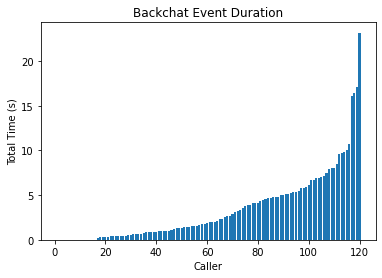

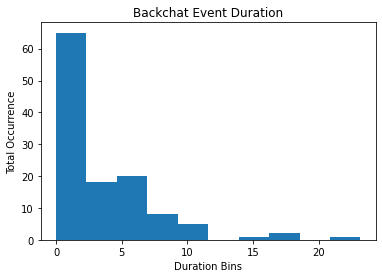

In [9]:
# Visualisation of backchat length duration
all_ids = get_all_call_ids(df)
backchat_list = []
for call in all_ids:
    backchat_list.append(total_time_of_event(get_call_df(df, call), "bc"))
backchat_list = sorted([val for sublist in backchat_list for val in sublist])
x = list(range(1, 121))
plt.bar(x, backchat_list)
plt.title('Backchat Event Duration')
plt.xlabel('Caller')
plt.ylabel('Total Time (s)')
plt.show()

plt.hist(backchat_list, 10)
plt.title('Backchat Event Duration')
plt.xlabel('Duration Bins')
plt.ylabel('Total Occurrence')
plt.show()

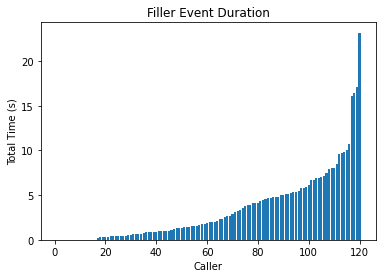

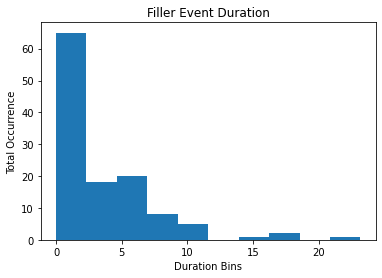

In [10]:
# Visualisation of filler length duration
all_ids = get_all_call_ids(df)
filler_list = []
for call in all_ids:
    filler_list.append(total_time_of_event(get_call_df(df, call), "bc"))
filler_list = sorted([val for sublist in filler_list for val in sublist])
x = list(range(1, 121))
plt.bar(x, filler_list)
plt.title('Filler Event Duration')
plt.xlabel('Caller')
plt.ylabel('Total Time (s)')
plt.show()

plt.hist(filler_list, 10)
plt.title('Filler Event Duration')
plt.xlabel('Duration Bins')
plt.ylabel('Total Occurrence')
plt.show()

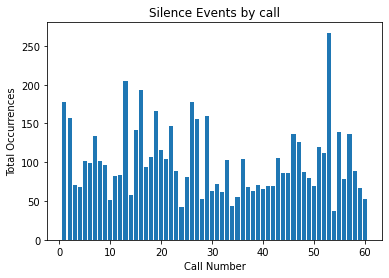

In [44]:
# Visualisation- cue by call ID
cue = "silence"
#cue = "laughter"
#cue = "bc"
#cue = "filler"
all_ids = get_all_call_ids(df)
laughter_events_list = []
for call in all_ids:
    laughter_events_list.append(occurrence_of_each_event(get_call_df(df, call), {cue:0}))
laughter_events_list = [val[cue] for val in laughter_events_list]

x = list(range(1, 61))
plt.bar(x, laughter_events_list)
plt.title(f'{cue.capitalize()} Events by call')
plt.xlabel('Call Number')
plt.ylabel('Total Occurrences')
plt.show()